## 1. MLP

page 61

In [1]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import loss as gloss, nn

%matplotlib inline

In [2]:
def xyplot(x_vals, y_vals, x_label, y_label):
    %config InlineBackend.figure_format = "retina"
    gb.plt.rcParams['figure.figsize'] = (3.5, 2.5)
    gb.plt.plot(x_vals, y_vals)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)

In [3]:
x = nd.arange(-5.0, 5.0, 0.1)

### Relu

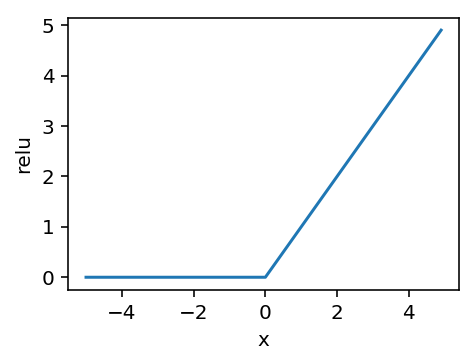

In [4]:
xyplot(x.asnumpy(), x.relu().asnumpy(), 'x', 'relu')

### Sigmoid

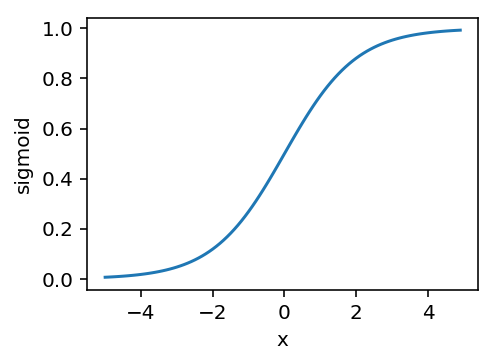

In [5]:
xyplot(x.asnumpy(), x.sigmoid().asnumpy(), 'x', 'sigmoid')

### Tanh

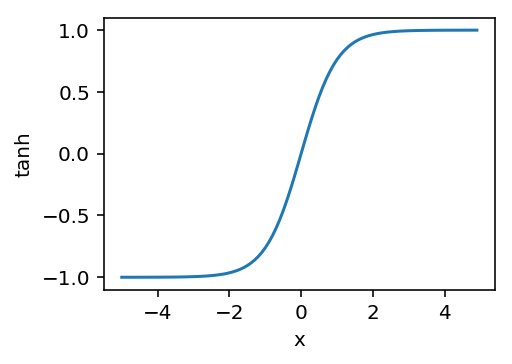

In [6]:
xyplot(x.asnumpy(), x.tanh().asnumpy(), 'x', 'tanh')

## 2. Manual MLP

page 68

In [7]:
from mxnet.gluon import loss as gloss

In [8]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)

In [9]:
num_inputs = 784
num_ouputs = 10
num_hiddens = 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_ouputs))
b2 = nd.zeros(num_ouputs)
params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

In [10]:
def relu(X):
    """
    manually for max(X, 0)
    """
    return nd.maximum(X, 0)

In [11]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [12]:
loss = gloss.SoftmaxCrossEntropyLoss()
num_epochs = 10
lr = 0.5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.7744, train acc 0.711, test acc 0.824
epoch 2, loss 0.4798, train acc 0.822, test acc 0.846
epoch 3, loss 0.4296, train acc 0.841, test acc 0.861
epoch 4, loss 0.3971, train acc 0.852, test acc 0.865
epoch 5, loss 0.3746, train acc 0.862, test acc 0.868
epoch 6, loss 0.3488, train acc 0.873, test acc 0.876
epoch 7, loss 0.3386, train acc 0.875, test acc 0.869
epoch 8, loss 0.3259, train acc 0.881, test acc 0.876
epoch 9, loss 0.3126, train acc 0.885, test acc 0.884
epoch 10, loss 0.3061, train acc 0.887, test acc 0.884


## 3.  Gluon MLP

page 71

In [13]:
from mxnet import gluon, init
from mxnet.gluon import loss as gloass, nn

In [14]:
net = nn.Sequential()
net.add(nn.Dense(num_hiddens, activation='relu'))
net.add(nn.Dense(num_ouputs))
net.initialize(init.Normal(sigma=0.01))

In [15]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)
loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 10
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 2.3036, train acc 0.076, test acc 0.074
epoch 2, loss 2.3036, train acc 0.076, test acc 0.074
epoch 3, loss 2.3036, train acc 0.076, test acc 0.074
epoch 4, loss 2.3035, train acc 0.076, test acc 0.074
epoch 5, loss 2.3036, train acc 0.076, test acc 0.074
epoch 6, loss 2.3036, train acc 0.076, test acc 0.074
epoch 7, loss 2.3036, train acc 0.076, test acc 0.074
epoch 8, loss 2.3036, train acc 0.076, test acc 0.074
epoch 9, loss 2.3036, train acc 0.076, test acc 0.074
epoch 10, loss 2.3036, train acc 0.076, test acc 0.074


## 4. Overfitting, underfitting and Model Selection

### 4.1 Poloynomial fitting experiment

In [16]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [17]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] + poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [18]:
def semilog(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, 
            legend=None, figsize=(3.5, 2.5)):
    gb.set_figsize(figsize)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)
    gb.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        gb.plt.semilogy(x2_vals, y2_vals, linestyle=":")
        gb.plt.legend(legend)

In [19]:
num_epochs = 100
loss = gloass.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print("final epoch: train loss", train_ls[-1], 'test loss', test_ls[-1])
    semilog(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
            range(1, num_epochs+1), test_ls, ['train', 'test'])
    return ('weight:', net[0].weight.data(), 'loss', net[0].bias.data())

final epoch: train loss 0.011918148 test loss 0.020094575


('weight:', 
 [[ 0.81023747 -3.300976    5.649498  ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [6.080889]
 <NDArray 1 @cpu(0)>)

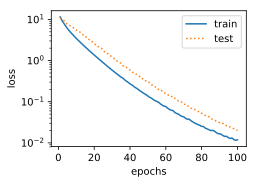

In [20]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

In [25]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, features, features)
labels = (true_w[0] + poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss 0.004841299 test loss 0.0053940113


('weight:', 
 [[1.090004  1.0548301 1.045057 ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [6.191002]
 <NDArray 1 @cpu(0)>)

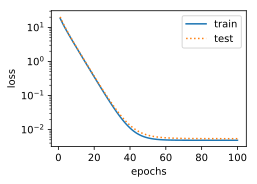

In [26]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

In [23]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] + poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss 4.9158454 test loss 121.00838


('weight:', 
 [[ 0.06154837 -0.3676647   0.4248855 ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [1.729694]
 <NDArray 1 @cpu(0)>)

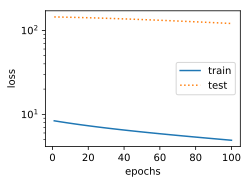

In [24]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])